In [1]:
from pathlib import Path 
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, OptimizeWarning
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import numpy as np
import seaborn as sns 


dataset_name = 'Second'
home_folder = '/home/debian/jz/'
timelapse_to_track = f'timelapse_{dataset_name.lower()}_dataset'
tracking_directory = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/nuclei_membrane_tracking/'
channel = 'nuclei_'

master_xml_name = 'master_' + 'marching_cubes_filled_' + channel + timelapse_to_track + ".xml"
xml_path = Path(os.path.join(tracking_directory, master_xml_name))

save_dir = os.path.join(tracking_directory, f'msd_plots_{channel}predicted')
data_frames_dir = os.path.join(tracking_directory, f'dataframes/')

Path(save_dir).mkdir(exist_ok=True, parents=True) 

dataframe_file = os.path.join(data_frames_dir , f'goblet_basal_dataframe_normalized_{channel}predicted.csv')

TIME_INTERVAL =  283



In [2]:
tracks_goblet_basal_radial_dataframe = pd.read_csv(dataframe_file)
cell_type_dataframe = tracks_goblet_basal_radial_dataframe[~tracks_goblet_basal_radial_dataframe['Cell_Type'].isna()]
cell_types = cell_type_dataframe['Cell_Type'].unique()

def power_law_msd(t, D, alpha):
    return D * t**alpha


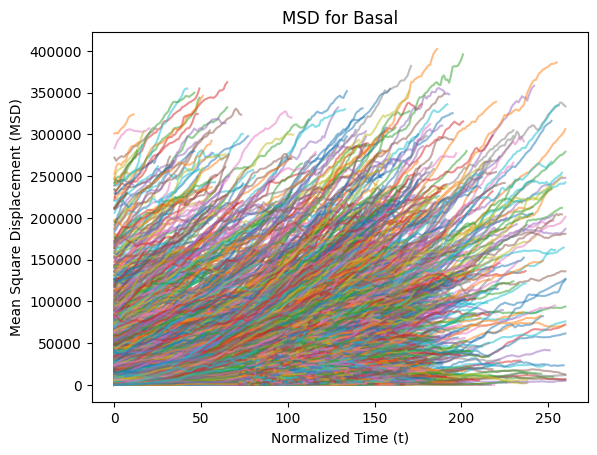

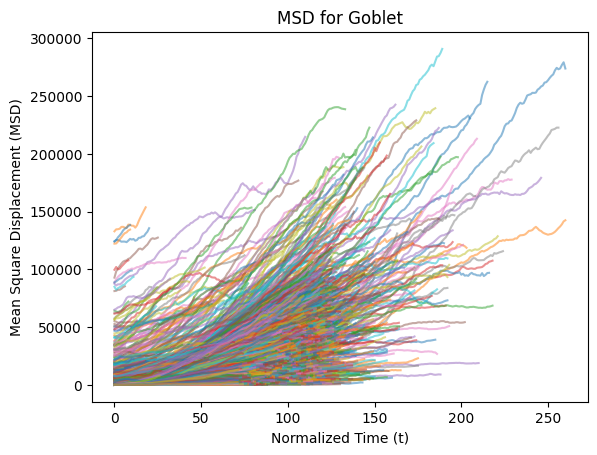

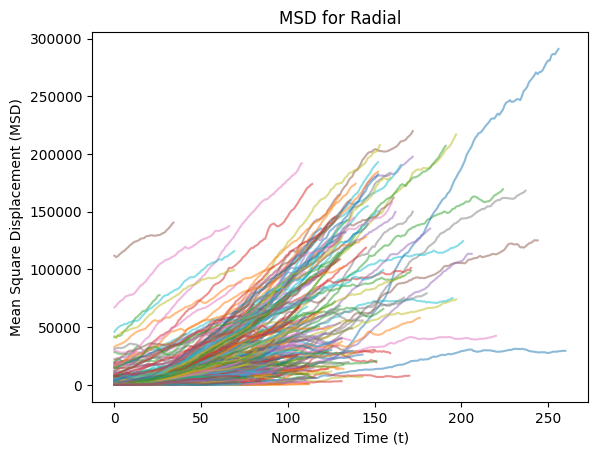

MSD analysis complete. Motion statistics saved as 'msd_motion_type_statistics.csv'.


<Figure size 1000x600 with 0 Axes>

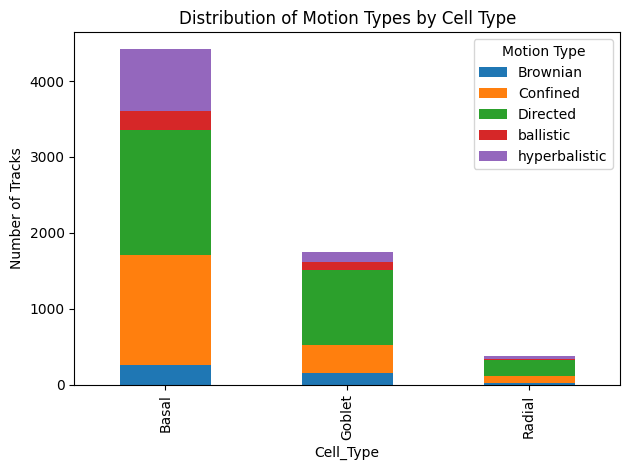

Motion type distribution plots saved by cell type.


In [3]:
motion_stats = {cell_type: {"ballistic": [], "Directed": [], "Brownian": [], "Confined": [], "hyperbalistic": []} for cell_type in cell_types}
fit_results = []

# Process data for fitting and categorizing tracks
for cell_type in cell_types:
    filtered_tracks = cell_type_dataframe[cell_type_dataframe['Cell_Type'] == cell_type]
    trackmate_track_ids = filtered_tracks['TrackMate Track ID'].unique()
    
    for trackmate_id in trackmate_track_ids:
        trackmate_data = filtered_tracks[filtered_tracks['TrackMate Track ID'] == trackmate_id]
        track_ids = trackmate_data['Track ID'].unique()
        
        for track_id in track_ids:
            track_data = trackmate_data[trackmate_data['Track ID'] == track_id].copy()
            track_data['t_normalized'] = track_data['t'] - track_data['t'].min()

            if len(track_data['t_normalized']) < 5 or len(track_data['MSD']) < 5:
                continue

            t_values = track_data['t_normalized'].values
            msd_values = track_data['MSD'].values
            poly_coeffs = np.polyfit(t_values, msd_values, deg=3)  
            poly_func = np.poly1d(poly_coeffs) 
            msd_smooth = poly_func(t_values)  

            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("error", OptimizeWarning)
                    popt, _ = curve_fit(power_law_msd, t_values, msd_smooth)
                    D_fit, alpha_fit = popt
                    D_fit = D_fit / TIME_INTERVAL  # Adjust diffusion constant based on the time interval
                    fit_results.append((track_id, D_fit, alpha_fit))

                    # Classify motion type based on alpha
                    if alpha_fit > 2.1:
                        motion_type = "hyperbalistic"
                    elif 1.9 < alpha_fit <= 2.1:
                        motion_type = "ballistic"
                    elif 1.1 < alpha_fit < 1.9:
                        motion_type = "Directed"
                    elif 0.9 < alpha_fit <= 1.1:
                        motion_type = "Brownian"
                    elif alpha_fit < 0.9:
                        motion_type = "Confined"

                    # Append D and alpha values to motion_stats for each motion type
                    motion_stats[cell_type][motion_type].append((D_fit, alpha_fit))
                    plt.plot(track_data['t_normalized'], track_data['MSD'], alpha=0.5)

            except (RuntimeError, OptimizeWarning):
                print(f"Could not fit MSD for TrackMate Track ID {trackmate_id} / Track ID {track_id} in Cell Type {cell_type}.")
                continue

    # Plot MSD for each cell type
    plt.title(f'MSD for {cell_type}')
    plt.xlabel('Normalized Time (t)')
    plt.ylabel('Mean Square Displacement (MSD)')
    plt.savefig(os.path.join(save_dir, f'MSD_Fit_{cell_type}.png'))
    plt.show()  

motion_data = []
for cell_type, motion_types in motion_stats.items():
    for motion_type, values in motion_types.items():
        for D_fit, alpha_fit in values:
            motion_data.append([cell_type, motion_type, D_fit, alpha_fit])

motion_stats_df = pd.DataFrame(motion_data, columns=['Cell_Type', 'Motion_Type', 'D', 'Alpha'])
motion_stats_df.to_csv(os.path.join(save_dir, 'msd_motion_type_statistics.csv'))

print("MSD analysis complete. Motion statistics saved as 'msd_motion_type_statistics.csv'.")

# Create a figure for motion type distribution by cell type
plt.figure(figsize=(10, 6))
motion_stats_df.groupby(['Cell_Type', 'Motion_Type']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribution of Motion Types by Cell Type')
plt.ylabel('Number of Tracks')
plt.legend(title='Motion Type')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'motion_type_distribution_bar_by_cell_type.png'))
plt.show()

# Create seaborn plots for D and Alpha distributions, and add means as tables
cell_types = motion_stats_df['Cell_Type'].unique()
motion_types = motion_stats_df['Motion_Type'].unique()



print("Motion type distribution plots saved by cell type.")

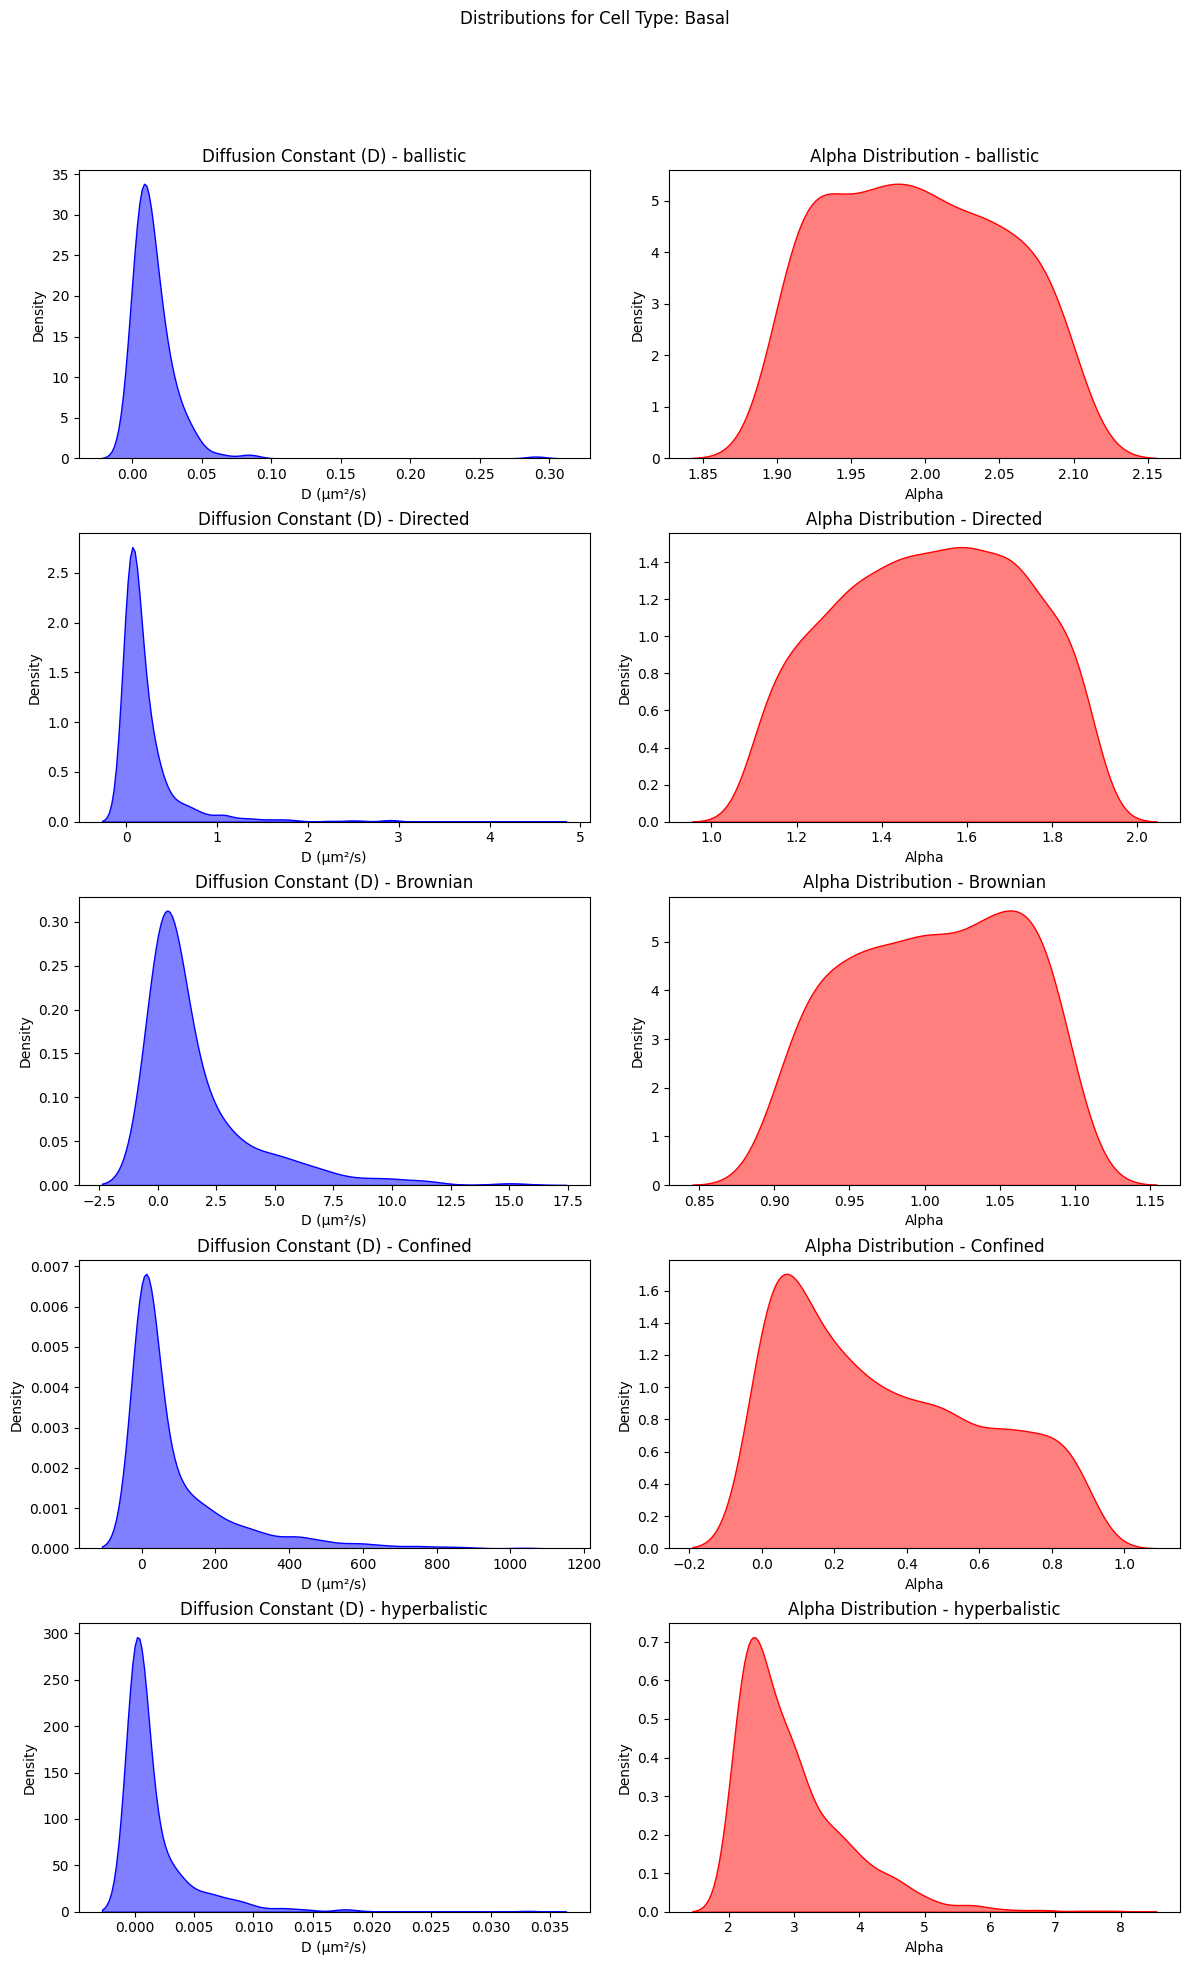

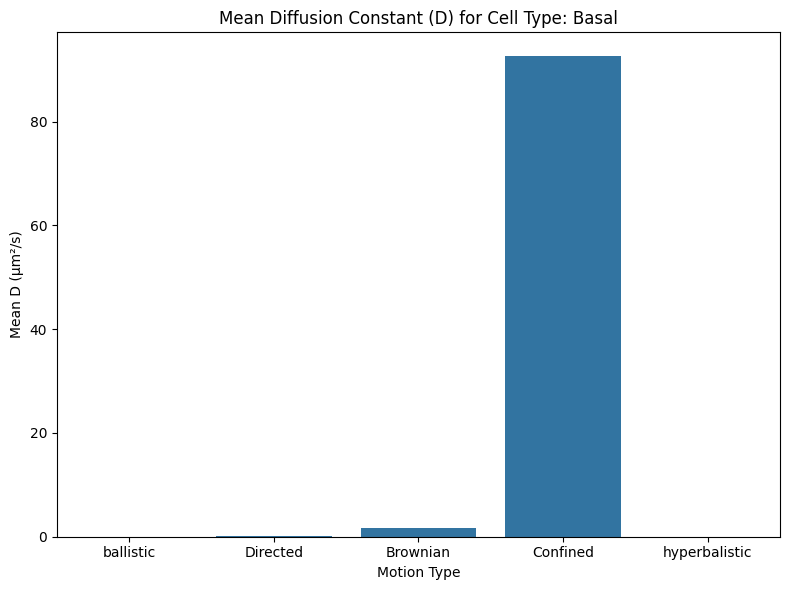

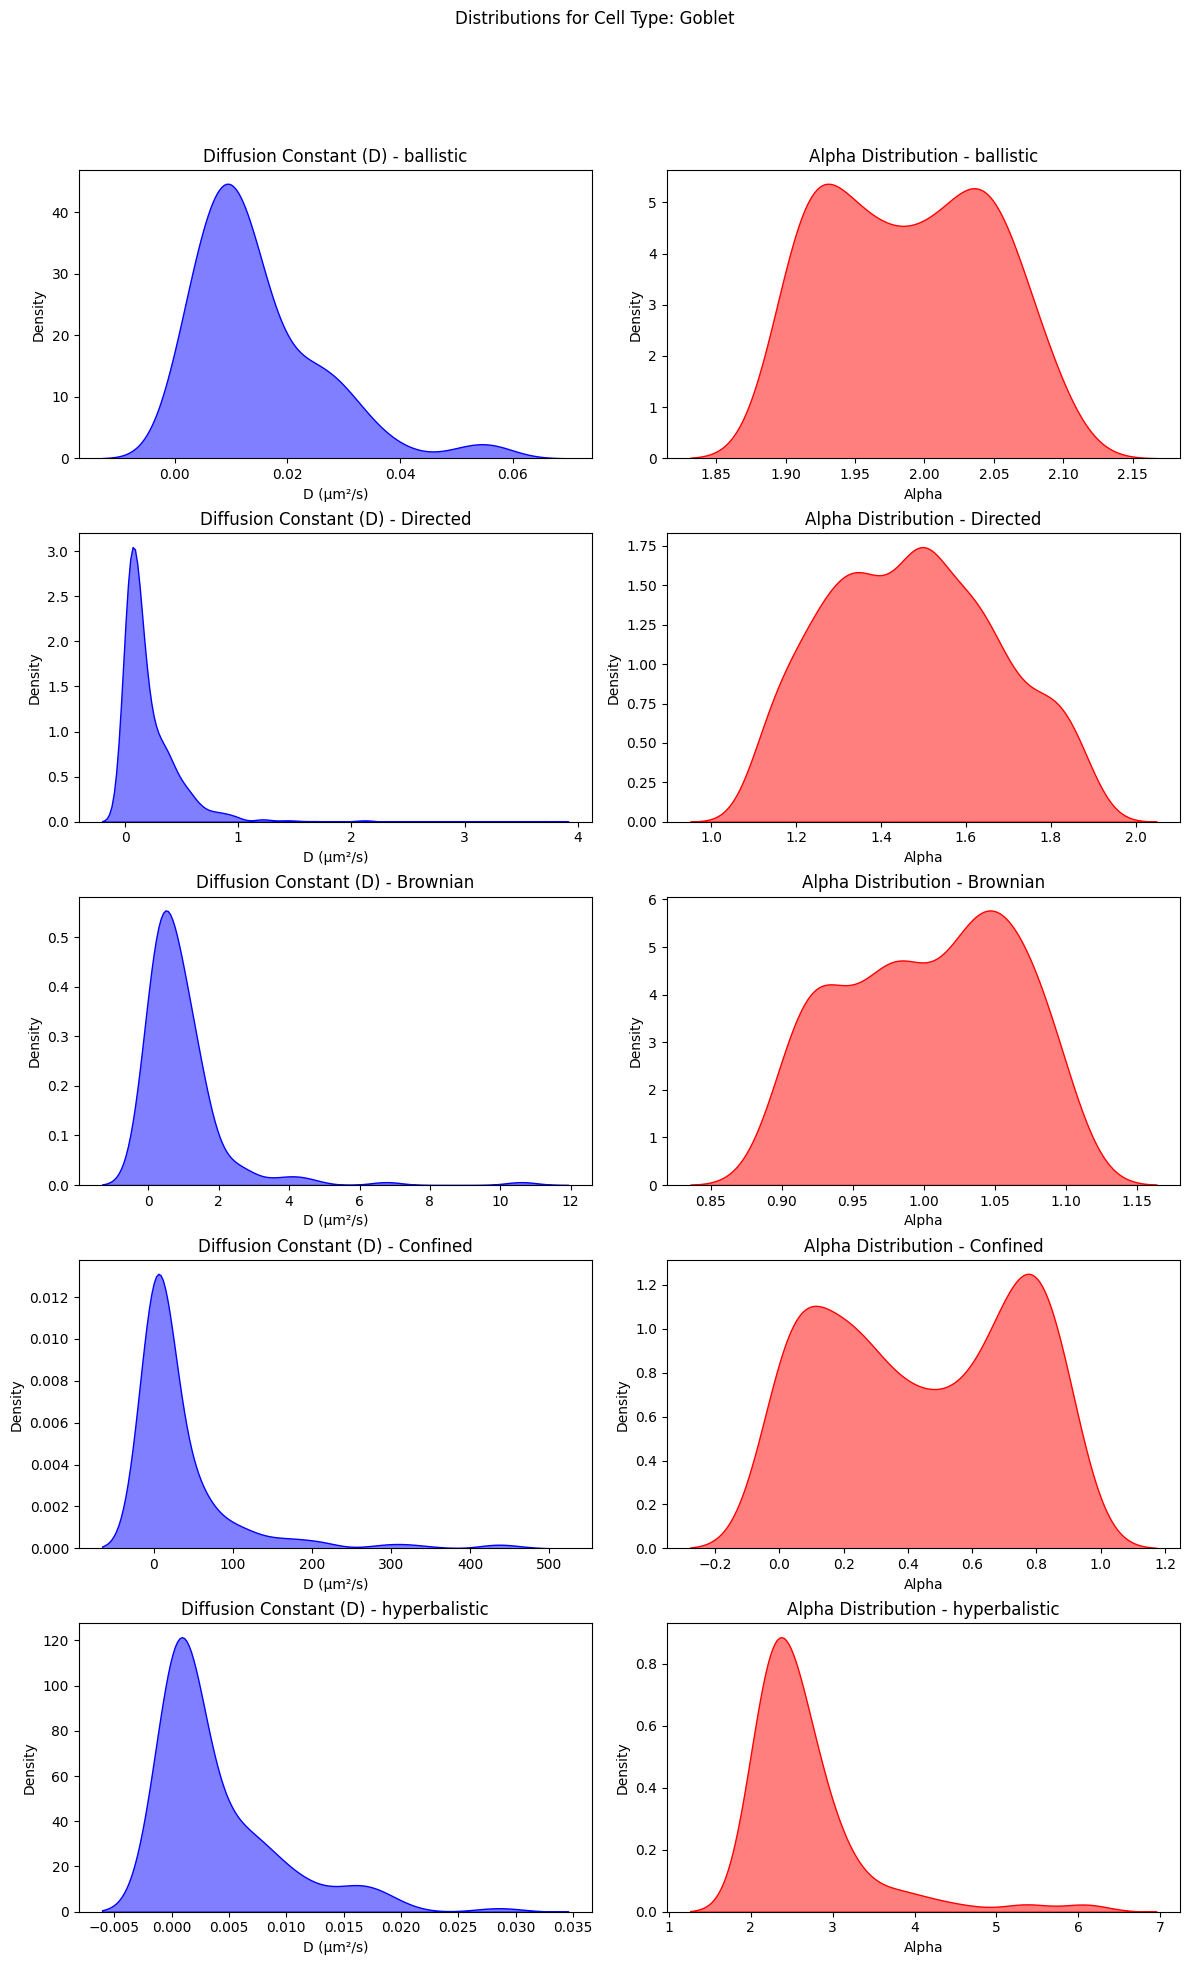

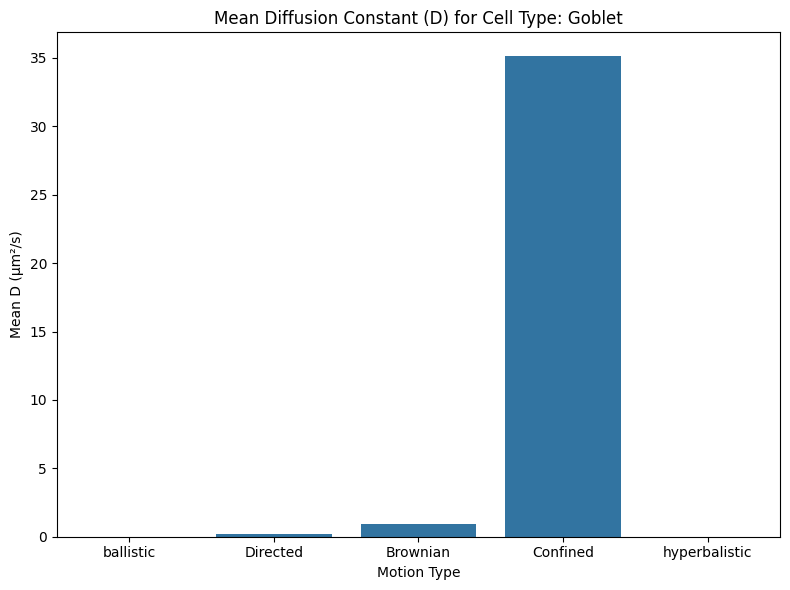

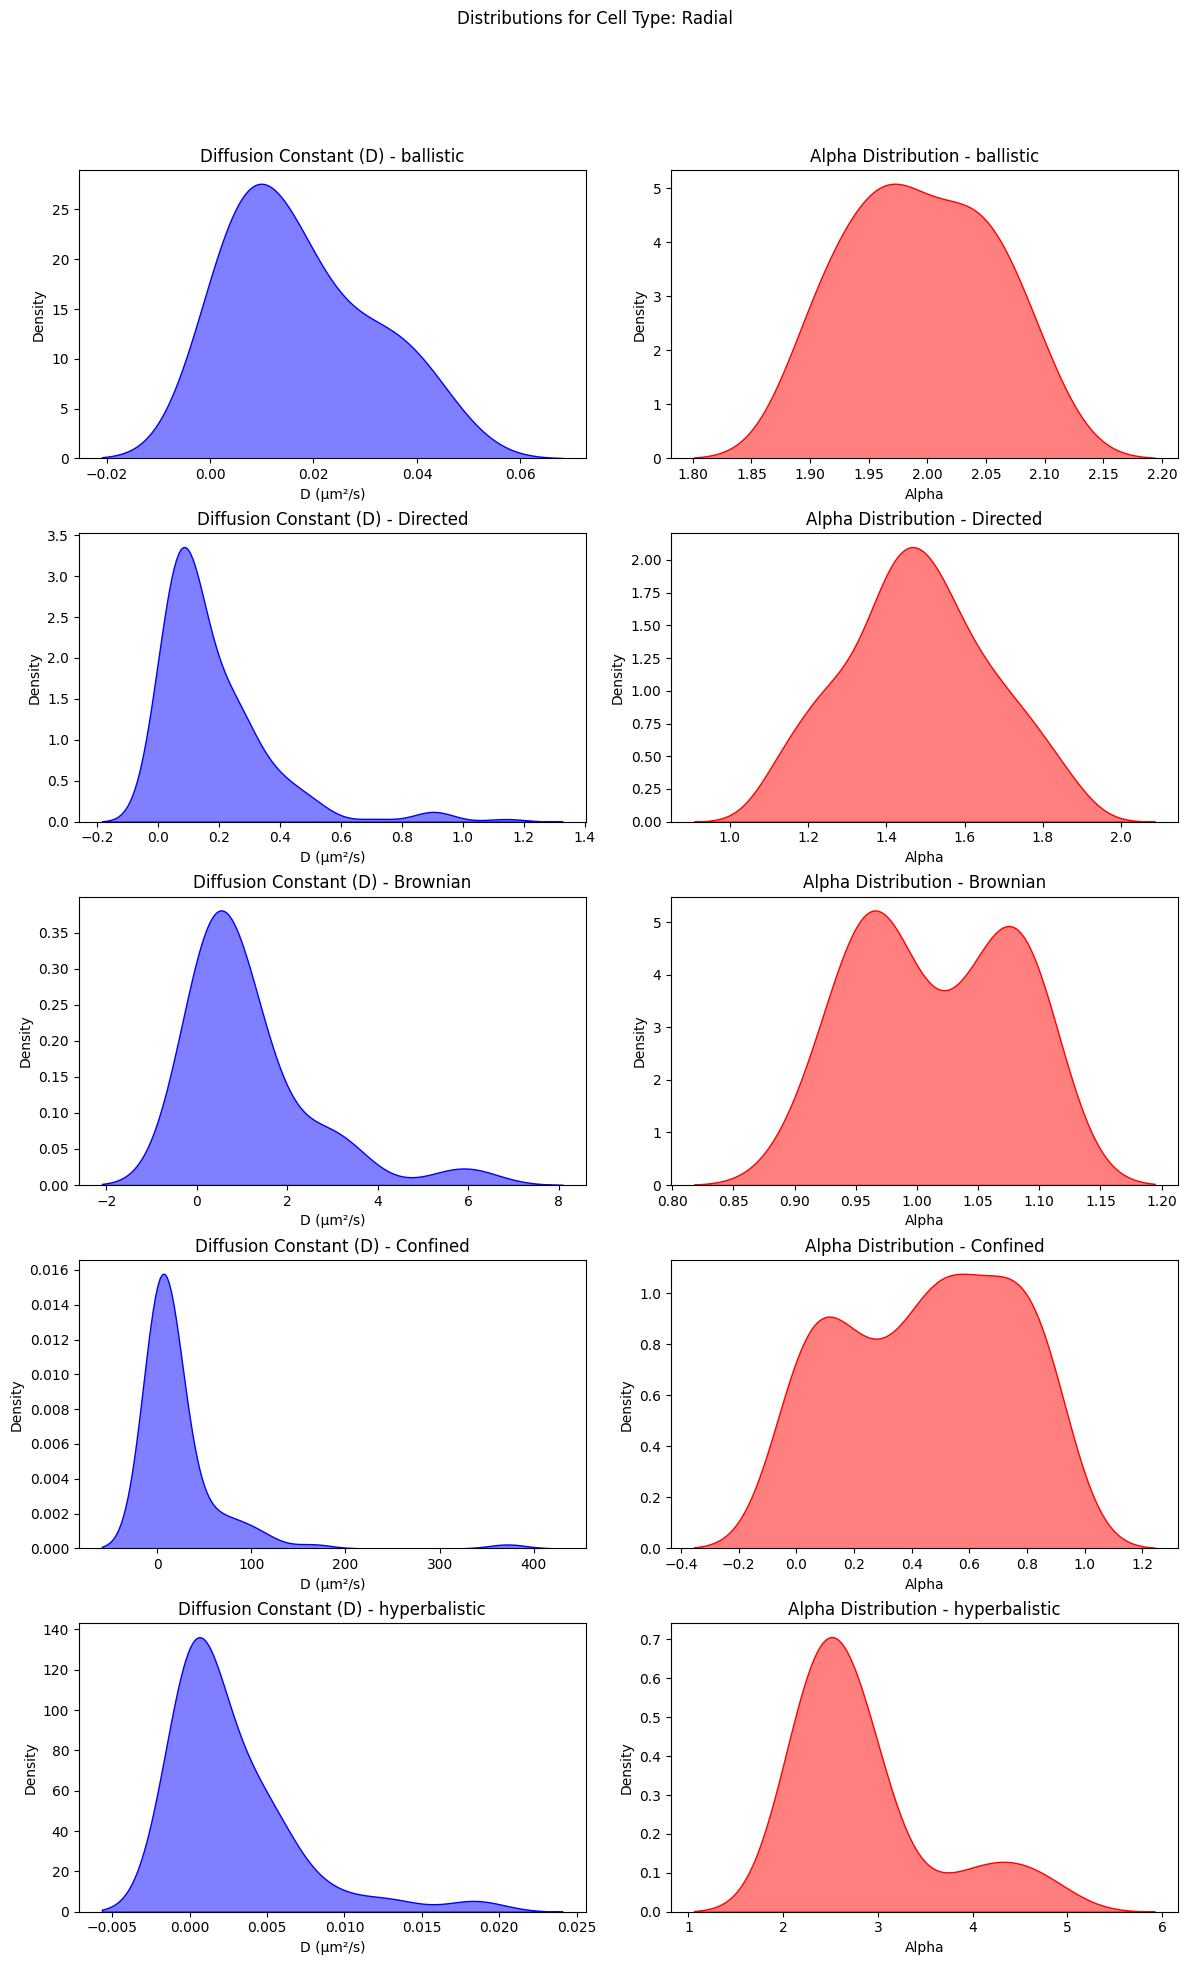

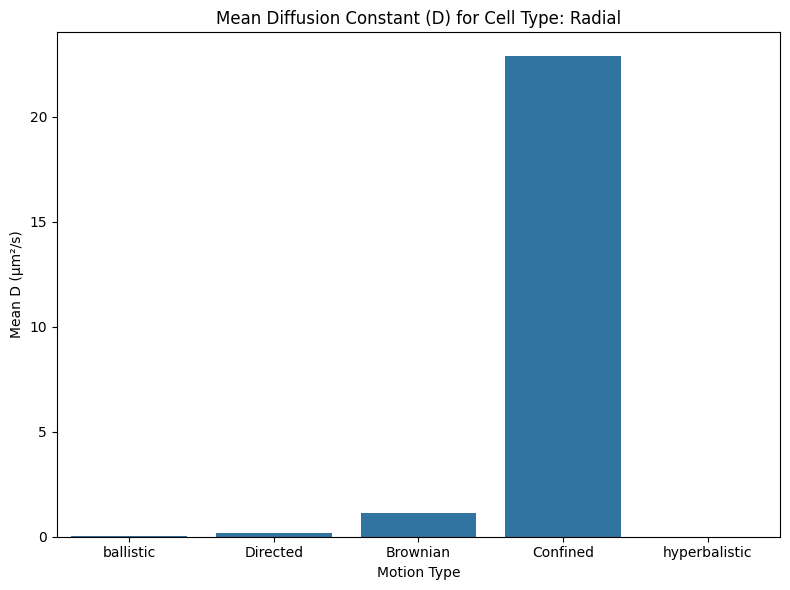

In [4]:

# Iterate through each cell type
for cell_type in cell_types:
    # Create subplots for Alpha and D distributions
    fig, axes = plt.subplots(len(motion_types), 2, figsize=(12, len(motion_types) * 4))
    cell_data = motion_stats_df[motion_stats_df['Cell_Type'] == cell_type]
    
    # Store mean values for plotting
    mean_values_list = []

    for i, motion_type in enumerate(motion_types):
        subset = cell_data[cell_data['Motion_Type'] == motion_type]

        # Seaborn KDE plot for D distribution (left column)
        sns.kdeplot(data=subset, x='D', fill=True, color='blue', ax=axes[i, 0], alpha=0.5)
        axes[i, 0].set_title(f'Diffusion Constant (D) - {motion_type}')
        axes[i, 0].set_xlabel('D (µm²/s)')
        axes[i, 0].set_ylabel('Density')

        # Seaborn KDE plot for Alpha distribution (right column)
        sns.kdeplot(data=subset, x='Alpha', fill=True, color='red', ax=axes[i, 1], alpha=0.5)
        axes[i, 1].set_title(f'Alpha Distribution - {motion_type}')
        axes[i, 1].set_xlabel('Alpha')
        axes[i, 1].set_ylabel('Density')

        # Calculate mean values for D and Alpha
        mean_D = subset['D'].mean()
        mean_alpha = subset['Alpha'].mean()
        mean_values_list.append([motion_type, mean_D, mean_alpha])

    plt.suptitle(f'Distributions for Cell Type: {cell_type}')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust layout for the suptitle
    plt.savefig(os.path.join(save_dir, f'{cell_type}_motion_type_diffusion_alpha_kde_distributions.png'))
    plt.show()

    # Convert the mean values list into a DataFrame
    mean_values_df = pd.DataFrame(mean_values_list, columns=['Motion_Type', 'Mean D', 'Mean Alpha'])

    # Plot the Mean D values as a bar plot
    plt.figure(figsize=(8, 6))
    sns.barplot(data=mean_values_df, x='Motion_Type', y='Mean D')
    plt.title(f'Mean Diffusion Constant (D) for Cell Type: {cell_type}')
    plt.xlabel('Motion Type')
    plt.ylabel('Mean D (µm²/s)')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{cell_type}_mean_diffusion_constant_barplot.png'))
    plt.show()

    # Optionally save the mean values as a CSV for reference
    mean_values_df.to_csv(os.path.join(save_dir, f'{cell_type}_motion_type_mean_values.csv'), index=False)